<center><h1>Wang_Jason_HW5</h1></center>
<br>
<br>

Name: Jason Wang
<br>
Github Username: jasonwangg1321
<br>
USC ID: 5363148736

## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import numpy as np
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor




### (a) Obtain Data

Get the Accute Inamations Data Set

In [2]:
data = pd.read_csv('diagnosis.data', encoding= 'UTF-16', delimiter= '\t')
columns = ['Temperature', 'Nausea', 'Lumbar', 'Urine', 'Micturition', 'Burning', 'Inflammation_Decision', 'Nephritis_Decision']
features = ['Temperature', 'Nausea', 'Lumbar', 'Urine', 'Micturition', 'Burning']
data.columns = columns
data

,Temperature,Nausea,Lumbar,Urine,Micturition,Burning,Inflammation_Decision,Nephritis_Decision
0,"35,9",no,no,yes,yes,yes,yes,no
1,"35,9",no,yes,no,no,no,no,no
2,"36,0",no,no,yes,yes,yes,yes,no
3,"36,0",no,yes,no,no,no,no,no
4,"36,0",no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
114,"41,4",no,yes,yes,no,yes,no,yes
115,"41,5",no,no,no,no,no,no,no
116,"41,5",yes,yes,no,yes,no,no,yes
117,"41,5",no,yes,yes,no,yes,no,yes


### (b) Build a decision tree

In [3]:
# Replacing yes and no with 1 and 0 
binary_data = data.replace({'yes': 1, 'no': 0})
binary_data['Temperature'] = binary_data['Temperature'].str.replace(',', '.').astype(float)
display(binary_data)

,Temperature,Nausea,Lumbar,Urine,Micturition,Burning,Inflammation_Decision,Nephritis_Decision
0,35.9,0,0,1,1,1,1,0
1,35.9,0,1,0,0,0,0,0
2,36.0,0,0,1,1,1,1,0
3,36.0,0,1,0,0,0,0,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
114,41.4,0,1,1,0,1,0,1
115,41.5,0,0,0,0,0,0,0
116,41.5,1,1,0,1,0,0,1
117,41.5,0,1,1,0,1,0,1


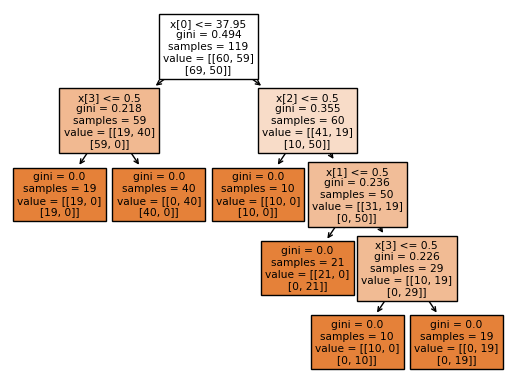

In [4]:
x_training = binary_data.iloc[0:,:-2]
y_training = binary_data.iloc[-0:, -2:]
model = DecisionTreeClassifier()
model.fit(x_training, y_training)
plot_tree(model, filled = True)
plt.show()


### (c) Convert the decision rules

In [5]:
# from https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
def tree_to_code(tree, feature_names):
	"""
	Outputs a decision tree model as a Python function
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as a function
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))
	recurse(0,1)

In [6]:
tree_to_code(model, features) 

def tree(Temperature, Nausea, Lumbar, Urine, Micturition, Burning):
  if Temperature <= 37.95000076293945:
    if Urine <= 0.5:
      return [[19.  0.]
 [19.  0.]]
    else:  # if Urine > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if Temperature > 37.95000076293945
    if Lumbar <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if Lumbar > 0.5
      if Nausea <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if Nausea > 0.5
        if Urine <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if Urine > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


Number of nodes in the last tree is: 1 with ccp_alpha: 0.20623086722226275


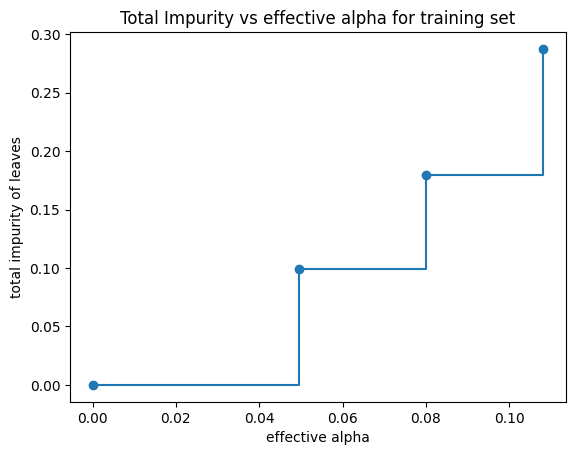

In [7]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html 
# the below is taken from scikit-learn.org to prune with cost complexitiy pruning
path = model.cost_complexity_pruning_path(x_training, y_training)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_training, y_training)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [8]:
# manually changed .data file to csv with column names added
data2 = pd.read_csv('communities.csv')
data2

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


### (b) Missing values

In [9]:
# will be imputing data by using median as mean may lead to skewed values from outliers using sklearn
unnecessary = data2.drop(data2.columns[0:5], axis =1)
unnecessary.replace('?', np.nan, inplace= True)
impute = SimpleImputer(strategy='median')
data2_clean = impute.fit_transform(unnecessary)
data2_clean = pd.DataFrame(data2_clean)
data2_clean.columns = unnecessary.columns
# display(data2_clean)

training = data2_clean[0:1495]
test = data2_clean[1495:]


### (c) Plot a correlation matrix

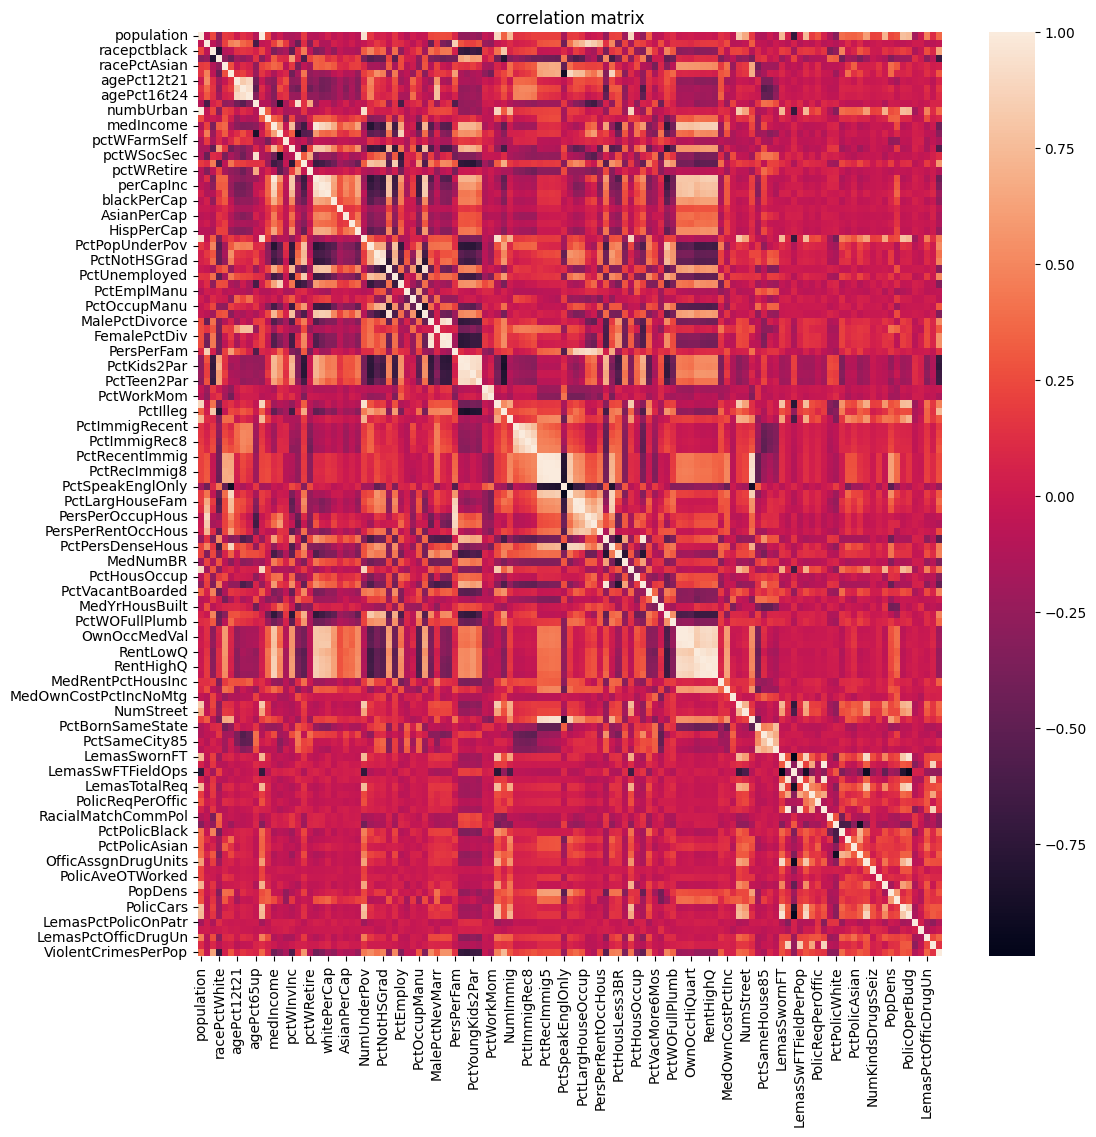

In [10]:
plt.figure(figsize=(12,12))
plt.title('correlation matrix')
corr = data2_clean.corr()
sns.heatmap(corr)
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [11]:
# CV - s/m where s is sample sd and m is sample mean
stats = data2_clean.describe()
sample_mean = stats.loc['mean']
sample_sd = stats.loc['std']

cv = sample_sd/sample_mean
display(cv)

population             2.203503
householdsize          0.353298
racepctblack           1.410920
racePctWhite           0.323782
racePctAsian           1.359162
                         ...   
LemasPctPolicOnPatr    0.117979
LemasGangUnitDeploy    0.333483
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.431524
ViolentCrimesPerPop    0.979015
Length: 123, dtype: float64

### (e) Scatter plots and box plots for highest CV features

<function matplotlib.pyplot.show(close=None, block=None)>

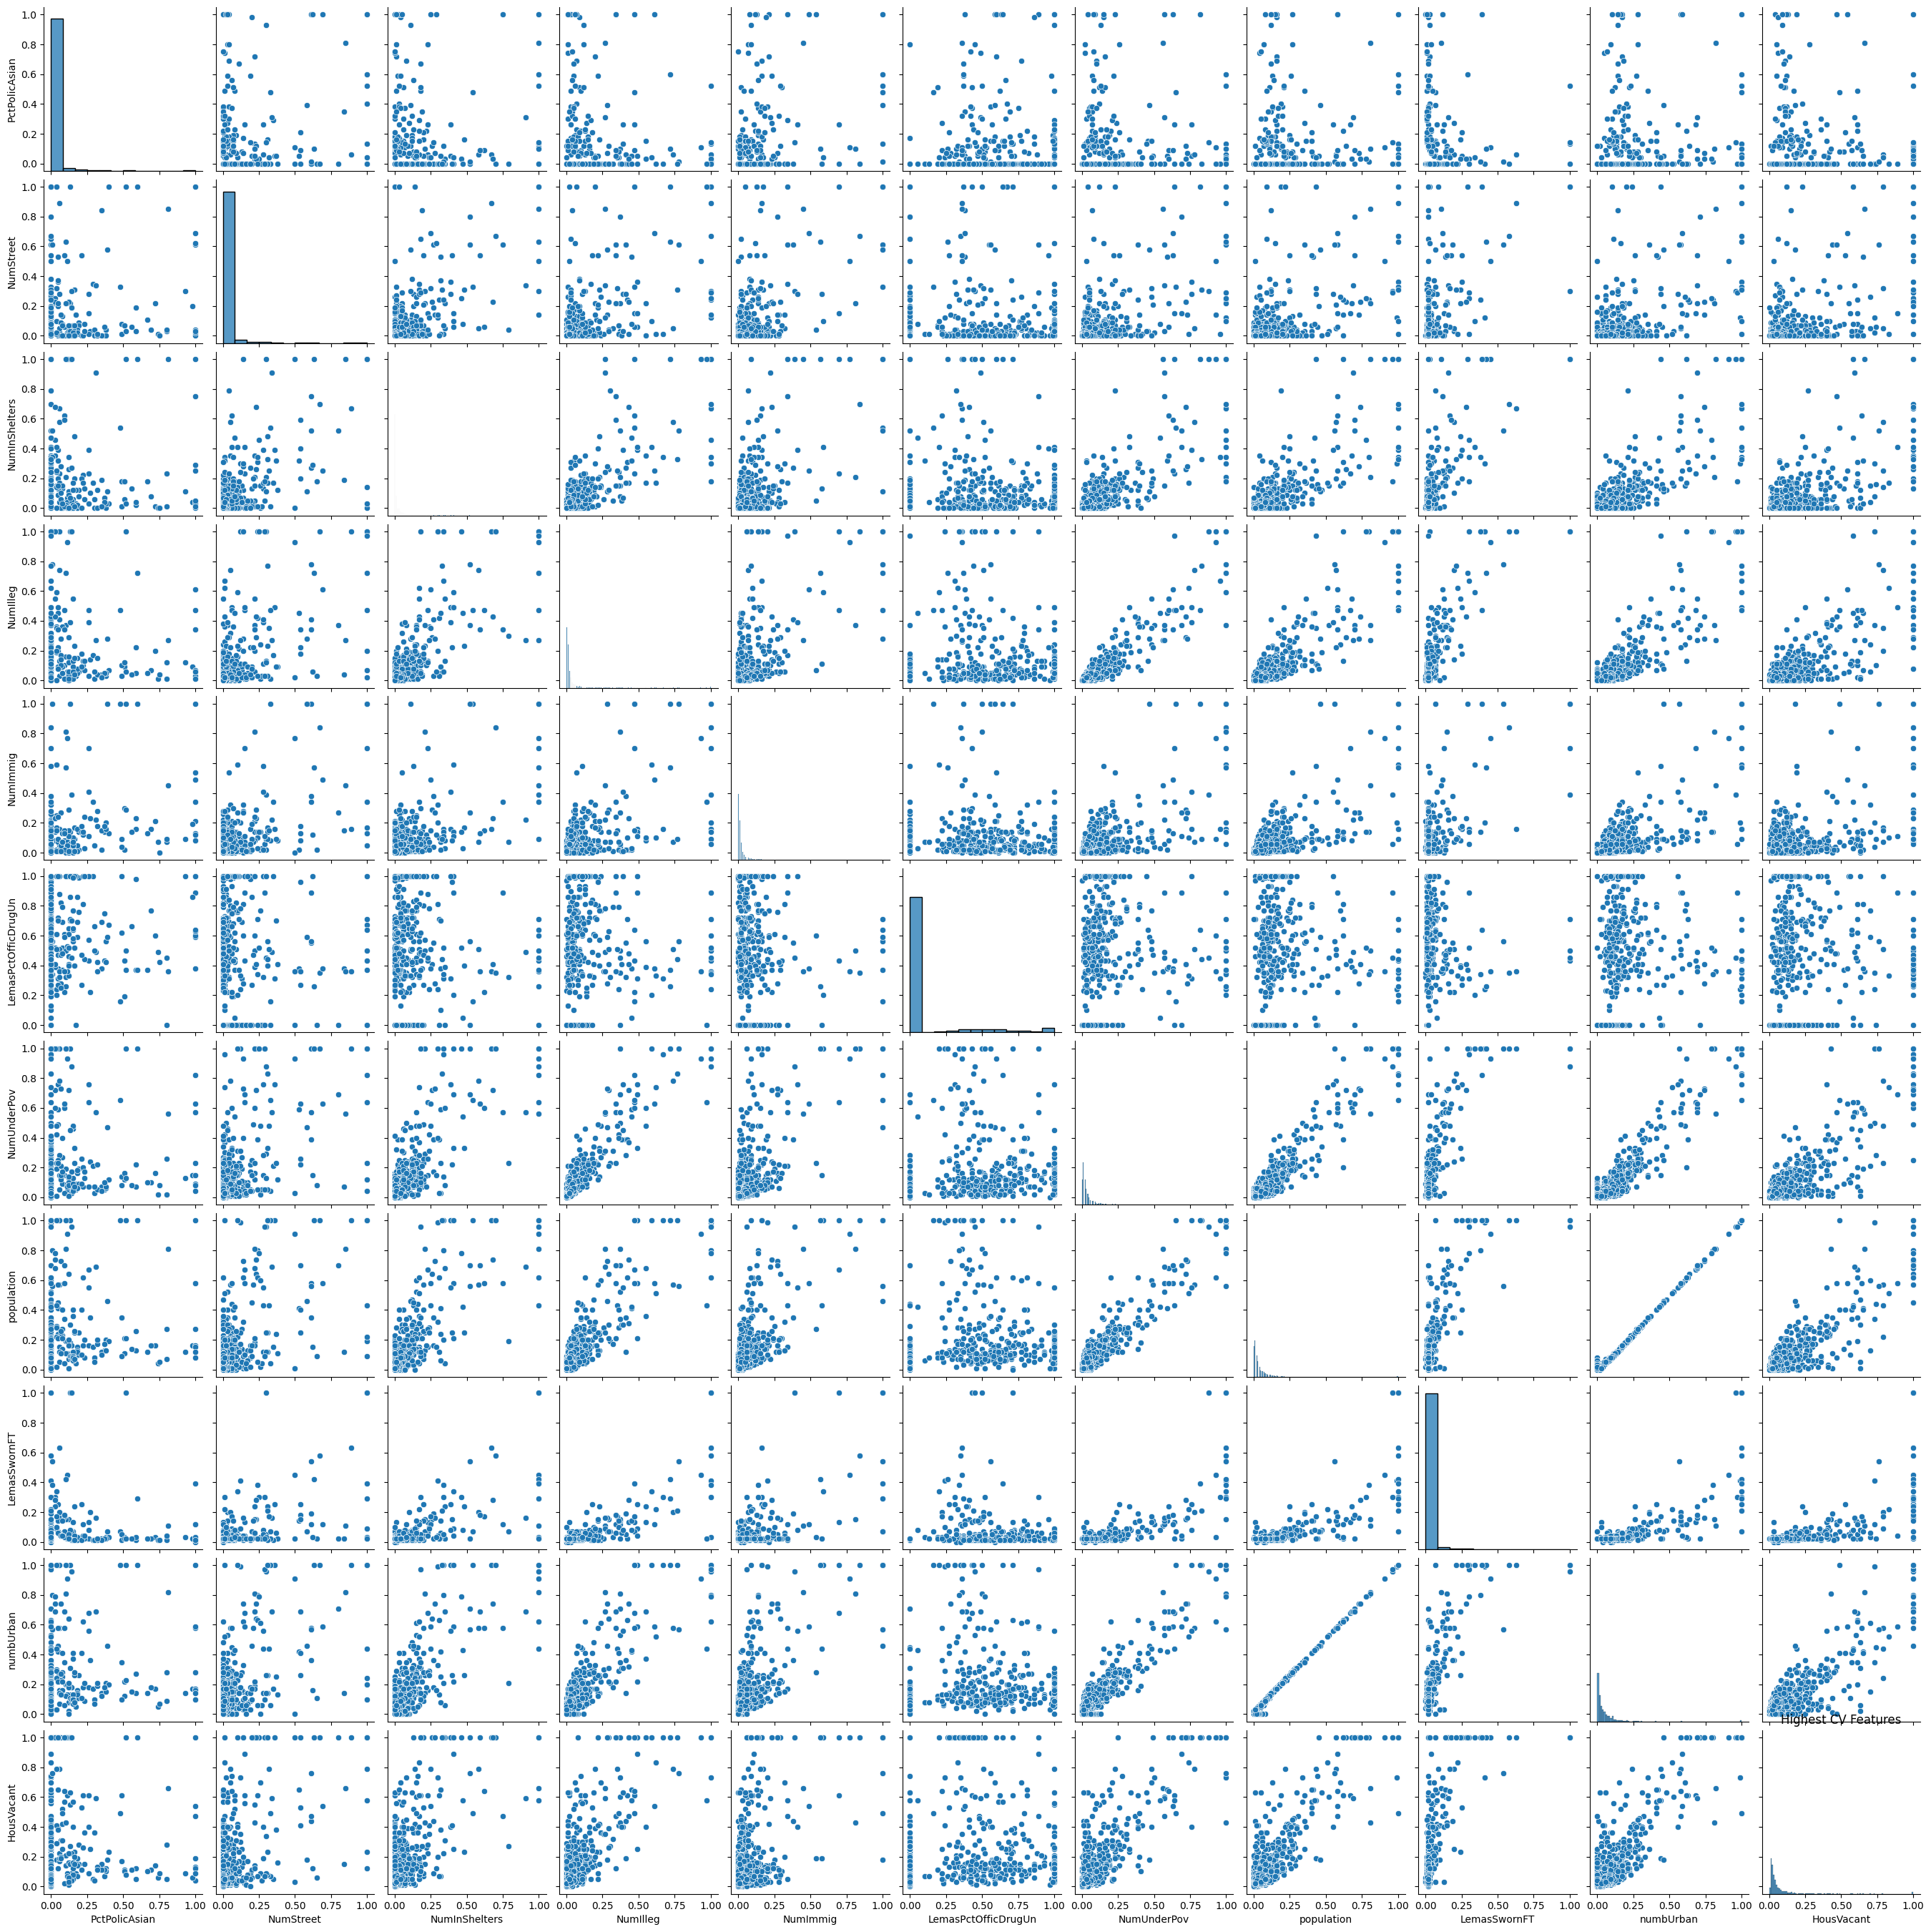

In [12]:
cv_df = pd.DataFrame(cv, columns= ['CV'])
# display(cv_df)
highest_val = cv_df['CV'].nlargest(math.floor(np.sqrt(128)))
wanted_features = ['PctPolicAsian', 'NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'LemasSwornFT', 'numbUrban', 'HousVacant']
wanted_features_df = data2_clean[wanted_features]
# display(wanted_features_df)
sns.pairplot(wanted_features_df)
plt.title('Highest CV Features')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

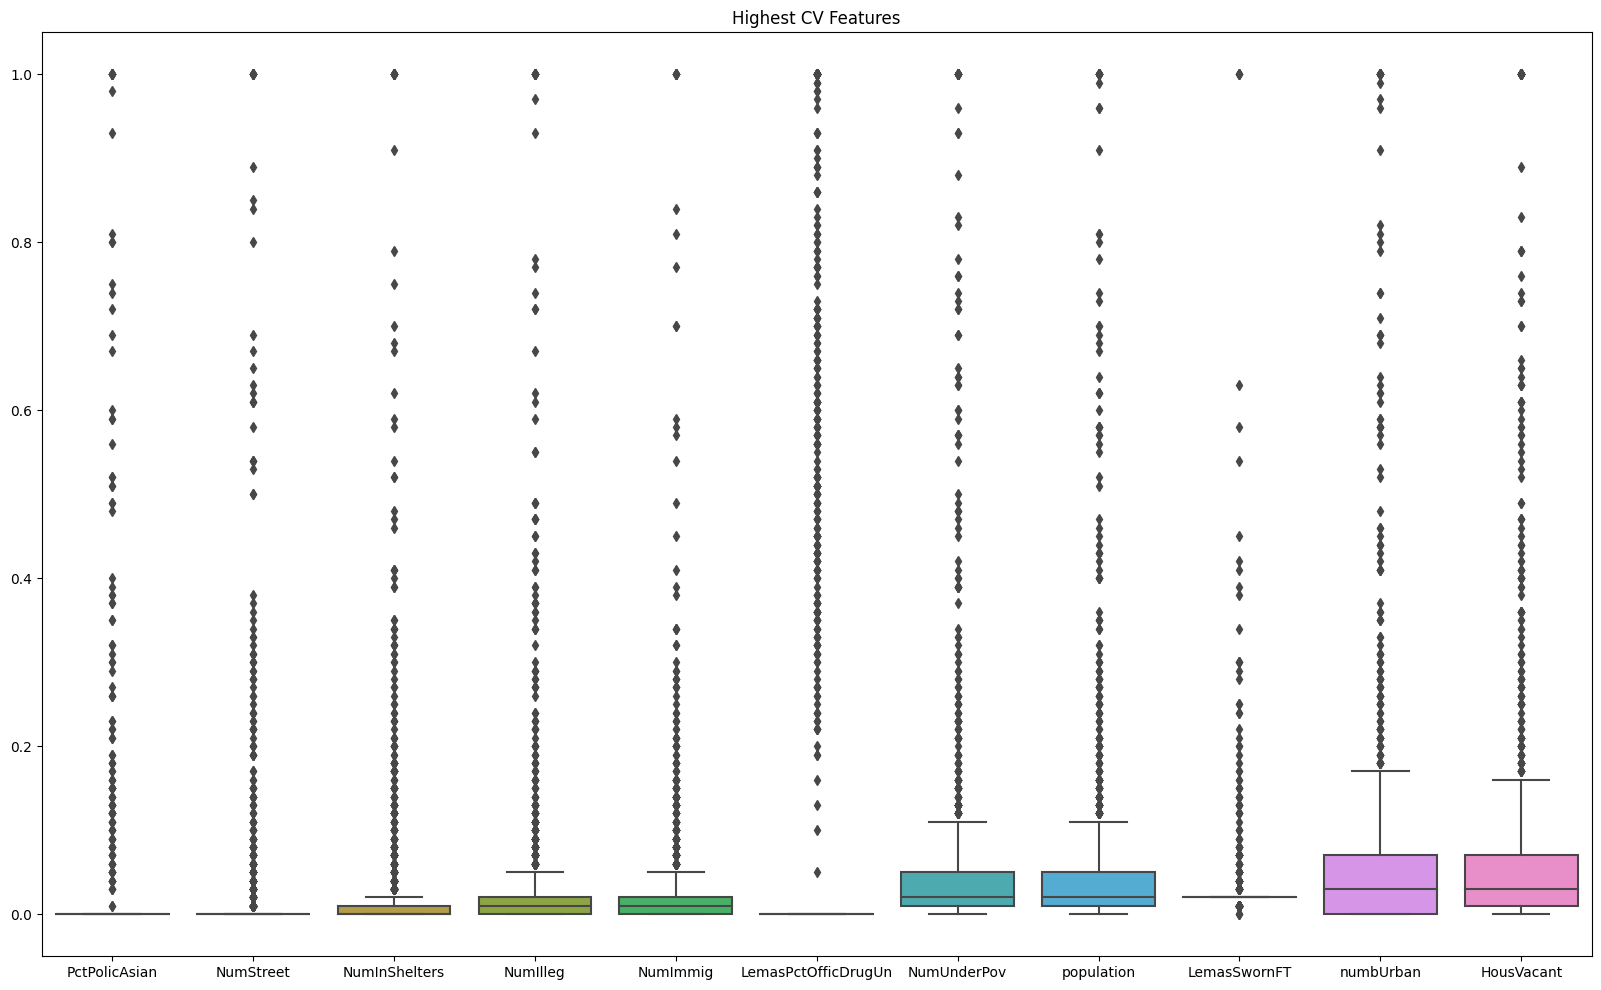

In [13]:
plt.figure(figsize=(20,12))
sns.boxplot(wanted_features_df)
plt.title('Highest CV Features')
plt.show

### (f) Fit a linear model

In [14]:
# training = data2_clean[0:1495]
# test = data2_clean[1495:]
x_training = training.iloc[0:,0:-1]
y_training = training.iloc[0:,-1:]
# y_training
x_test = test.iloc[0:,0:-1]
y_test = test.iloc[0:,-1:]


In [15]:
x_training_cons = sm.add_constant(x_training)
lr = sm.OLS(y_training,x_training_cons)
results = lr.fit()

x_test_cons = sm.add_constant(x_test)
y_pred = results.predict(x_test_cons)
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE: {test_mse}')


Test MSE: 0.017976972571643574


### (g) Fit a ridge regression model

In [16]:
alpha = [0.01, 0.1, 1, 10, 100]
ridge = RidgeCV(alphas= alpha, cv = 10)
ridge.fit(x_training, y_training)
y_pred_ridge = ridge.predict(x_test)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)

print(f'best alpha is {ridge.alpha_}')
print(f'Test MSE: {ridge_mse}')

best alpha is 1.0
Test MSE: 0.017630963071705714


### (h) Fit a LASSO model

In [17]:
lasso = LassoCV(alphas = alpha, cv = 5)
lasso.fit(x_training, y_training.values.ravel())
#print(x_training)
y_pred_lasso = lasso.predict(x_test)

lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print(f'test MSE: {lasso_mse}')

feature_names = x_training.columns
variables = lasso.coef_

variable = dict(zip(feature_names, variables))
important_var = {feature: variable_val for feature, variable_val in variable.items() if variable_val != 0}
print(important_var)


    

test MSE: 0.020919681104181242
{'racePctWhite': -0.19191760646146855, 'PctKids2Par': -0.24656867723805634, 'PctIlleg': 0.21574201177345742}


In [18]:
scaler = StandardScaler()
x_training_scaled = scaler.fit_transform(x_training)
x_training_scaled_df = pd.DataFrame(x_training_scaled, columns= x_training.columns)
# display(x_training_scaled_df)
y_training_scaled = scaler.fit_transform(y_training)
y_training_scaled = y_training_scaled.flatten()

lasso.fit(x_training_scaled_df, y_training_scaled)
y_pred_standardized_lasso = lasso.predict(x_test)
lasso_standardized_mse = mean_squared_error(y_test, y_pred_standardized_lasso)
print(f'test MSE: {lasso_standardized_mse}')

feature_names2 = x_training.columns
variables2 = lasso.coef_

variable2 = dict(zip(feature_names2, variables2))
important_var2 = {feature2: variable_val2 for feature2, variable_val2 in variable2.items() if variable_val2 != 0}
print(important_var2)



test MSE: 0.07292342527726803
{'racepctblack': 0.24653106662957985, 'agePct12t29': -0.052865741090102704, 'pctUrban': 0.06236989674895011, 'pctWInvInc': -0.03672732743870091, 'pctWPubAsst': 0.011094329967604587, 'pctWRetire': -0.038664944112881676, 'indianPerCap': -0.011563432384541494, 'AsianPerCap': 0.014817430925546998, 'OtherPerCap': 0.006900761530533132, 'HispPerCap': 0.0007381014087905663, 'PctPopUnderPov': -0.004507689931273996, 'MalePctDivorce': 0.0749435206147255, 'PctKids2Par': -0.19161347454393046, 'PctYoungKids2Par': -0.019120692461934447, 'PctWorkMom': -0.05092809095461373, 'PctIlleg': 0.13281379870773513, 'NumImmig': -0.004881803129497753, 'PctPersDenseHous': 0.11948100532539911, 'PctHousLess3BR': 0.03595408259940363, 'HousVacant': 0.060243383922446006, 'PctHousOccup': -0.04214864121413347, 'PctVacantBoarded': 0.0441046364886719, 'PctVacMore6Mos': -0.020993657873415394, 'PctWOFullPlumb': -0.0064164560712485766, 'MedRent': 0.006085818159241673, 'MedRentPctHousInc': 0.04242

We can see that the standardized lasso has a higher test MSE while also having more important features.

### (i) Fit a PCR model

In [19]:
# I used ChatGpt to help write the below because I was having issues writing an algorithm that would correctly 
# perform PCR along with cross validation on the training set. Was encountering errors where I couldn't fit my 
# regression model to the data. ChatGPT introduced the pipeline method with the GridSearchCV method in the below ti cross validate and find the MSE
pipeline = Pipeline([ 
    ('pca', PCA()),
    ('model', LinearRegression())
])

param_grid = {'pca__n_components': range(1,123)}
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(x_training, y_training)

best_n_components = grid_search.best_params_['pca__n_components']

best_score = -grid_search.best_score_  
print(f"Optimal number of components: {best_n_components}")


Optimal number of components: 96


In [20]:
cv_components = PCA(n_components = 96)
x_pca = cv_components.fit_transform(x_training)
x_pca_cons = sm.add_constant(x_pca)
lr = sm.OLS(y_training, x_pca_cons)
results = lr.fit()

x_test_pca = cv_components.transform(x_test) 
x_test_pca_cons = sm.add_constant(x_test_pca)
y_pred = results.predict(x_test_pca_cons)
test_mse = mean_squared_error(y_test,y_pred)
print(f'Test MSE: {test_mse}')


Test MSE: 0.01834768191243163


### (j) Fit a boosting tree

In [21]:
#https://machinelearningmastery.com/xgboost-for-regression/
xgb = XGBRegressor()

param_grid = {'alpha': alpha}
grid_search = GridSearchCV(xgb, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(x_training, y_training)
print("best parameter: ", grid_search.best_params_)




best parameter:  {'alpha': 1}


Can see that the best alpha would be 1.